<a href="https://colab.research.google.com/github/libra0901/fmml-jan-/blob/main/svm_classifier_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries** <a class="anchor" id="6"></a>


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
from sklearn.datasets import load_breast_cancer
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# **Import dataset** <a class="anchor" id="7"></a>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = 'drive/MyDrive/diabetes.csv'

In [ ]:
df = pd.read_csv(data)

# **Exploratory data analysis** <a class="anchor" id="8"></a>


In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Explore missing values in variables

In [ ]:
df.isnull().values.any()

False

In [ ]:
remove_zeros = ["Glucose","BloodPressure","SkinThickness"]

for column in remove_zeros:
    df[column] = df[column].replace(0, np.NaN)
    mean = int(df[column].mean(skipna = True))
    df[column] = df[column].replace(np.NaN, mean)

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
df.columns = ['Pregnancies','Glucose',  'BloodPressure','SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:

df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
df['Outcome'].value_counts()/np.float(len(data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


0    19.230769
1    10.307692
Name: Outcome, dtype: float64

### Outliers in numerical variables

In [ ]:
round(df.describe(),2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,121.68,72.39,29.11,79.80,31.99,0.47,33.24,0.35
std,3.37,30.44,12.10,8.79,115.24,7.88,0.33,11.76,0.48
min,0.00,44.00,24.00,7.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.75,64.00,25.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,29.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


# **Declare feature vector and target variable** <a class="anchor" id="9"></a>


In [ ]:
X = df.drop(['Outcome'], axis=1)

y = df['Outcome']

# **Split data into separate training and test set** <a class="anchor" id="10"></a>


In [ ]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [ ]:
X_train.shape, X_test.shape

((614, 7), (154, 7))

# **Feature Scaling** <a class="anchor" id="11"></a>


In [ ]:
cols = X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
count,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02
mean,-3.498830e-17,3.878548e-17,-1.274767e-16,-1.406200e-16,-2.412113e-16,-4.383030e-16,-8.444204e-17
std,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00
min,-1.126063e+00,-2.569036e+00,-4.051300e+00,-2.514453e+00,-6.996567e-01,-4.072759e+00,-1.166818e+00
25%,-8.354355e-01,-7.501685e-01,-7.187506e-01,-4.775304e-01,-6.996567e-01,-5.951922e-01,-6.862388e-01
50%,-2.541807e-01,-1.218324e-01,-5.224070e-02,-2.488098e-02,-3.844838e-01,2.444697e-02,-2.927647e-01
75%,6.177016e-01,6.387851e-01,6.142692e-01,3.994779e-01,4.077076e-01,5.776962e-01,4.205946e-01
max,3.814603e+00,2.523793e+00,4.113446e+00,7.896485e+00,6.506730e+00,4.412504e+00,5.867657e+00


# **Run SVM with default hyperparameters** <a class="anchor" id="12"></a>


Default hyperparameter means C=1.0,  kernel=`rbf` and gamma=`auto` among other parameters.

In [ ]:
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.8117


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with rbf kernel and C=100.0




In [ ]:
svc=SVC(C=100.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with rbf kernel and C=100.0 : 0.7403


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with rbf kernel and C=1000.0


In [ ]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with rbf kernel and C=1000.0 : 0.7143


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# **Run SVM with linear kernel** <a class="anchor" id="13"></a>



### Run SVM with linear kernel and C=1.0

In [ ]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 


# fit classifier to training set
linear_svc.fit(X_train,y_train)


# make predictions on test set
y_pred_test=linear_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.8052


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with linear kernel and C=100.0

In [ ]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0) 


# fit classifier to training set
linear_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with linear kernel and C=100.0 : 0.8052


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with linear kernel and C=1000.0

In [ ]:
# instantiate classifier with linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0) 


# fit classifier to training set
linear_svc1000.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc1000.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with linear kernel and C=1000.0 : 0.8052


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Compare the train-set and test-set accuracy



In [ ]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,

### Check for overfitting and underfitting

In [ ]:

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.7622
Test set score: 0.8052


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
y_test.value_counts()

0    107
1     47
Name: Outcome, dtype: int64

In [ ]:

null_accuracy = (107/(107+47))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.6948


In [ ]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0) 


# fit classifier to training set
poly_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=poly_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with polynomial kernel and C=1.0 : 0.7403


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 


# fit classifier to training set
poly_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=poly_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with polynomial kernel and C=100.0 : 0.7532


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc1000=SVC(kernel='poly', C=1000.0) 


# fit classifier to training set
poly_svc1000.fit(X_train, y_train)


# make predictions on test set
y_pred=poly_svc1000.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with polynomial kernel and C=1000.0 : 0.7597


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
y_pred_train = poly_svc.predict(X_train)

y_pred_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:

print('Training set score: {:.4f}'.format(poly_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(poly_svc.score(X_test, y_test)))

Training set score: 0.7818
Test set score: 0.7403


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# **Run SVM with sigmoid kernel** <a class="anchor" id="15"></a>


### Run SVM with sigmoid kernel and C=1.0

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0) 


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=1.0 : 0.7597


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with sigmoid kernel and C=100.0

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=100.0) 


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=100.0 : 0.6753


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### Run SVM with sigmoid kernel and C=1000.0

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1000.0) 


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with sigmoid kernel and C=1000.0 : 0.7143


In [ ]:

print('Training set score: {:.4f}'.format(sigmoid_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(sigmoid_svc.score(X_test, y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Training set score: 0.6808
Test set score: 0.7143


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# **Confusion matrix** <a class="anchor" id="16"></a>


In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[96 11]
 [19 28]]

True Positives(TP) =  96

True Negatives(TN) =  28

False Positives(FP) =  11

False Negatives(FN) =  19


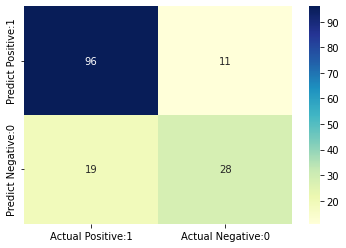

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **Classification metrices** 

### Classification Report




In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       107
           1       0.72      0.60      0.65        47

    accuracy                           0.81       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.80      0.81      0.80       154



In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

### Classification accuracy

In [ ]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.8052


### Classification error

In [ ]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.1948


### Precision


In [ ]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Precision : 0.8972


### Recall




In [ ]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.8348


### True Positive Rate



In [ ]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.8348


### False Positive Rate

In [ ]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.2821


### Specificity

In [ ]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.7179


## VISUALIZATION 

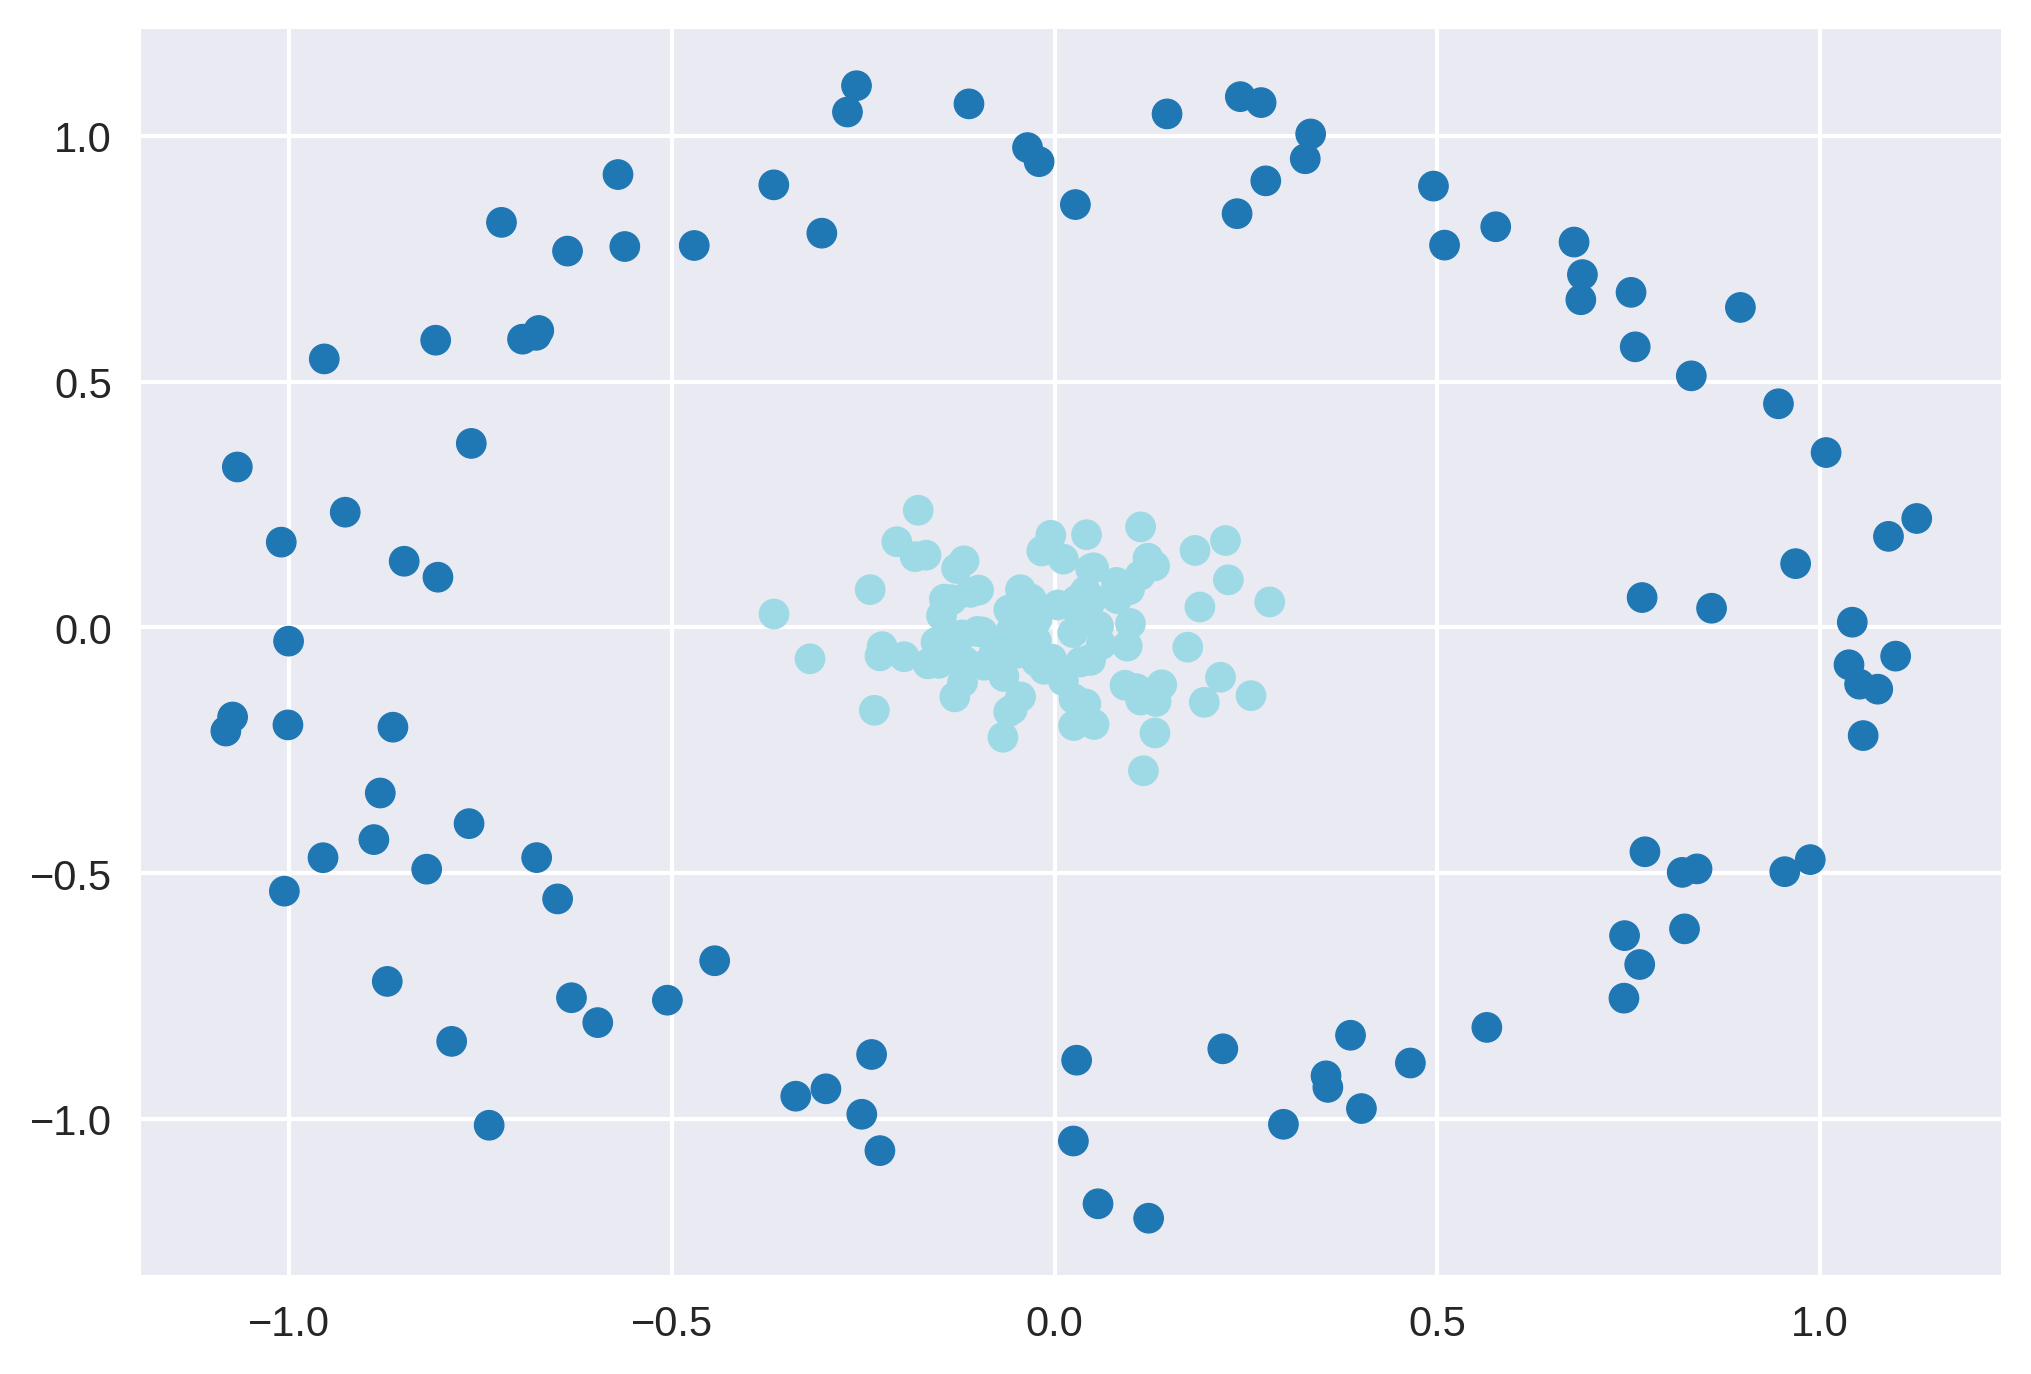

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(200, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)

plt.style.use("seaborn")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab20')
plt.gcf().set_dpi(300)